In [ ]:
DeepSMILESGenerator

Calculate with: NVIDIA GeForce MX150


2024-10-29 17:29:33,121 - INFO - Processing 0/4564 SMILES:


SMILES 1/4564: Nc1nc2cc(-c3ccc4ncc(C(=O)N5CCOCC5)n4c3)ccc2o1
DeepSMILES 1/4564: Ncnccc-ccccnccC=O)NCCOCC6)))))))n5c9)))))))))ccc6o9 

SMILES 2/4564: N#CCC1CCN(c2nc(Nc3ccc(N4CCC(O)CC4)cc3)c3c(=O)[nH]ncc3n2)CC1
DeepSMILES 2/4564: N#CCCCCNcncNccccNCCCO)CC6))))))cc6)))))))cc=O)[nH]ncc6n%10))))))))))CC6 

SMILES 3/4564: CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3cc(C(C)(C)C)nn3-c3ccc4ncccc4c3)c(F)c2)ccn1.Cc1ccc(S(=O)(=O)O)cc1
DeepSMILES 3/4564: CNC=O)cccOccccNC=O)NcccCC)C)C))nn5-ccccncccc6c%10))))))))))))))))))cF)c6)))))))ccn6.CccccS=O)=O)O))cc6 

SMILES 4/4564: N#CCC1(n2cc(-c3ncnc4[nH]ccc34)cn2)CN(S(=O)(=O)C2CC2)C1
DeepSMILES 4/4564: N#CCCncc-cncnc[nH]ccc95)))))))))cn5)))))CNS=O)=O)CCC3))))C4 

SMILES 5/4564: CC1(C)CC=C(c2nc(C3CC(C)(C)OC(C)(C)C3)ccc2NC(=O)c2nc(C#N)c[nH]2)CC1.Cl
DeepSMILES 5/4564: CCC)CC=CcncCCCC)C)OCC)C)C6))))))ccc6NC=O)cncC#N))c[nH]5)))))))))))))CC6.Cl 

Testing SMILES: Nc1nc2cc(-c3ccc4ncc(C(=O)N5CCOCC5)n4c3)ccc2o1
DeepSMILES: Ncnccc-ccccnccC=O)NCCOCC6)))))))n5c9)))))))))ccc6o9
Encoded 

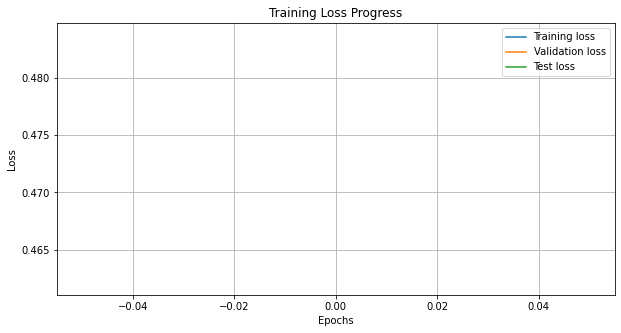

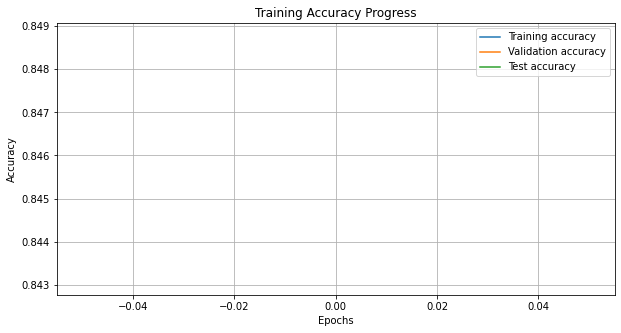


 Loaded pretrained model from C:\Users\SchockWav3\Desktop\Masterarbeit\Modelle\model_generator_pretrained_1908.pth 

Fine-tuning is not activated. Only the LSTM model training was performed.


In [7]:
import os
import re
from os import path
from typing import List, Tuple, Union
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdPartialCharges
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import csv
import random
import logging
import matplotlib.pyplot as plt
import deepsmiles

# Suppression of ‘please use MorgenGenerator’ error message 
from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')


# User-defined parameters
LEARNING_RATE = 0.00010
BATCH_SIZE = 128
EPOCHS = 1
AUGMENT = True
AUGMENT_FACTOR = 2
USE_PRETRAINED_MODEL = True
LOAD_MODEL_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\Modelle\\model_generator_pretrained_1908.pth'
SAVE_MODEL_PATH = 'C:\\Users\\SchockWav3\\Desktop\\müll3'
FILE_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\ChemblNIHDatensatzAXLKinase.txt'
ACTIVATE_FINE_TUNING = False



# 1. Set device for computation (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Calculate with: {torch.cuda.get_device_name(0)}")

else:
    device = torch.device("cpu")
    print(f"Calculate with: {device}")


    
# 2. Vocabulary
class FixedVocabulary:
    def __init__(self):
        self.token_to_index = {
            'PAD':      0,       # Padding token (for filling unequal batches)
            'UNK':      1,       # Undefined token (for unknown elements)
            '^':        2,       # Start token
            '$':        3,       # End token
            '3':        4,
            '4':        5,
            '5':        6,
            '6':        7,
            '7':        8,
            '8':        9,
            '9':        10,
            '%10':      11,
            '%11':      12,
            '%12':      13,
            '%13':      14,
            '%14':      15,
            '%15':      16,
            '%16':      17,
            '%17':      18,
            '%18':      19,
            '%19':      20,
            '%20':      21,
            '%21':      22,
            '%22':      23,
            '%23':      24,
            '%24':      25,
            ')':        26,
            '=':        27,
            '#':        28,
            '.':        29,
            '-':        30,
            '/':        31,
            '\\':       32, 
            'n':        33,
            'o':        34,
            'c':        35,
            's':        36,
            'N':        37,
            'O':        38,
            'C':        39,
            'S':        40,
            'F':        41,
            'P':        42,
            'I':        43,
            'B':        44,
            'Br':       45,
            'Cl':       46,
            '[C@]':     47,
            '[C@H]':    48,
            '[C@@H]':   49,
            '[C@@]':    50,
            '[nH]':     51,
            '[O-]':     52,
            '[N+]':     53,
            '[n+]':     54,
            '[Na+]':    55,
            '[S+]':     56,
            '[Br-]':    57,
            '[Cl-]':    58,
            '[I-]':     59,
            '[N-]':     60,
            '[Si]':     61,
            '[2H]':     62,
            '[K+]':     63,
            '[Se]':     64,
            '[P+]':     65,
            '[C-]':     66,
            '[se]':     67,
            '[Cl+3]:':  68,
            '[Li+]:':   69,      
        }
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

        
    def __len__(self):
        return len(self.token_to_index)
    

    def __getitem__(self, key):
        """
        This method allows direct access to indices or tokens by treating the vocabulary object as a dictionary.
        """
        if isinstance(key, int):
            return self.index_to_token.get(key, '?')  # Returns '?' if the index does not exist
        if isinstance(key, str):
            return self.token_to_index.get(key, self.token_to_index['UNK'])  # Returns UNK index if the token does not exist


    def __contains__(self, item):
        """
        This method checks whether a specific element (token or index) is present in the vocabulary. 
        It helps to avoid errors by preventing non-existent elements from being processed.
        """
        if isinstance(item, str):
            return item in self.token_to_index
        elif isinstance(item, int):
            return item in self.index_to_token
        return False
    

    def encode(self, tokens):
        return [self.token_to_index.get(token, self.token_to_index['UNK']) for token in tokens]
    

    def decode(self, indices):
        return [self.index_to_token.get(index, '?') for index in indices]


    def tokens(self):
        """
        A method to return all tokens in the vocabulary. Useful for inspecting the entire vocabulary.
        """
        return list(self.token_to_index.keys())



# 3.Tokenizer
class DeepSMILESTokenizer:
    """
    Handles the transformation of SMILES into deepSMILES and the
    tokenization and untokenization
    """
    def __init__(self, vocabulary):

        self.vocabulary = vocabulary
        self.converter = deepsmiles.Converter(rings=True, branches=True)

        self.REGEXPS = {
            "brackets": re.compile(r"(\[[^\]]*\])"),
            "2_ring_nums": re.compile(r"(%\d{2})"),
            "brcl": re.compile(r"(Br|Cl)")
        }
        self.REGEXP_ORDER = ["brackets", "2_ring_nums", "brcl"]


    # Encodes SMILES into deepSMILES if a value could not be determined output "UNK" token    
    def encode(self, smiles: str) -> str:
        """
        Encodes SMILES into deepSMILES.
        """
        try:
            deep_smiles = self.converter.encode(smiles)
            return deep_smiles
        except Exception as e:
            print("Could not convert SMILES to DeepSMILES:", e)
            return self.vocabulary['UNK']



    def tokenize(self, deep_smiles: str, with_begin_and_end: bool = True) -> list:
        """
        Tokenizes a deepSMILES string using the regex and checks if tokens are in vocabulary.
        This method ensures that all tokens are either recognized or marked as 'UNK'.
        """
        def split_by(data, regexps):
            if not regexps:
                return list(data)
            regexp = self.REGEXPS[regexps[0]]
            splitted = regexp.split(data)
            tokens = []
            for i, split in enumerate(splitted):
                if i % 2 == 0:
                    tokens += split_by(split, regexps[1:])
                else:
                    tokens.append(split)
            return [token if token in self.vocabulary else 'UNK' for token in tokens]

        tokens = split_by(deep_smiles, self.REGEXP_ORDER)  # Apply regex first
        if with_begin_and_end:
            tokens = ["^"] + tokens + ["$"]
        return tokens


    def untokenize(self, tokens : list) -> str:
        """
        Untokenizes a deepSMILES string, reconstructing it from the token list,
        excluding special tokens like '^', '$', and 'UNK'.
        """
        return ''.join(token for token in tokens if token not in ['^', '$', 'UNK'])



# 4. Define RNN
class RNN(torch.nn.Module):
    """
    Implements LSTM including an embedding layer and an output linear layer back to the size of the vocabulary.
    
     Params:
     
        voc_size (int)             : Size of the vocabulary (provided by the vocabulary class).
        layer_size (int)           : Size of each of the RNN layers.
        num_layers (int)           : Number of RNN layers.
        embedding_layer_size (int) : Size of the embedding layer.
        dropout (float)            : Dropout probabilities.
        layer_normalization (bool) : Whether or not to use layer normalization.
    """

    default_params = {
        "layer_size": 512,
        "num_layers": 3,
        "embedding_layer_size": 128,
        "dropout": 0.2,
        "layer_normalization": False
    }
    
    def __init__(self, vocabulary, **kwargs):
        super(RNN, self).__init__()

        # Retrieve vocabulary size directly from the passed vocabulary
        voc_size = len(vocabulary)  # Size of the vocabulary

        params = {**self.default_params, **kwargs}

        self._layer_size                = params['layer_size']
        self._embedding_layer_size      = params['embedding_layer_size']
        self._num_layers                = params['num_layers']
        self._dropout                   = params['dropout']
        self._layer_normalization       = params['layer_normalization']


        # Initialize the embedding layer with a specific padding_idx
        self.embedding = nn.Embedding(num_embeddings=voc_size,
                                      embedding_dim=self._embedding_layer_size,
                                      padding_idx=vocabulary['PAD']  # Use 'PAD' as the padding index
        )
        
        # LSTM RNN-Setup
        self.rnn = nn.LSTM(input_size=self._embedding_layer_size,
                           hidden_size=self._layer_size,
                           num_layers=self._num_layers,
                           dropout=self._dropout if self._num_layers > 1 else 0,
                           batch_first=True
        )

        # Linear output layer mapping RNN output back to the vocabulary size
        self.linear = nn.Linear(self._layer_size, voc_size)


    def forward(self, input_vector, hidden_state=None):
        """
        Performs a forward pass on the model.
        Params:
        ------
            input_vector (torch.Tensor)         : Input tensor (batch_size, seq_size).
            hidden_state (torch.Tensor or None) : Hidden state tensor.
        """
        batch_size, seq_size = input_vector.size()

        if hidden_state is None:
            device = input_vector.device
            hidden_state = (torch.zeros(self._num_layers, batch_size, self._layer_size, device=device),
                            torch.zeros(self._num_layers, batch_size, self._layer_size, device=device))

        embedded_data = self.embedding(input_vector)
        output_vector, hidden_state_out = self.rnn(embedded_data, hidden_state)

        if self._layer_normalization:
            output_vector = torch.nn.functional.layer_norm(output_vector, output_vector.size()[1:])

        output_data = self.linear(output_vector)  # Ensure the output is three-dimensional
        return output_data, hidden_state_out
    

    def get_params(self):
        """
        Returns the configuration parameters of the model.
        """
        return {
            "layer_size": self._layer_size,
            "num_layers": self._num_layers,
            "embedding_layer_size": self._embedding_layer_size,
            "dropout": self._dropout,
            "layer_normalization": self._layer_normalization
        }


    
# 5. Define LSTM
class SmilesLSTM(nn.Module):
    def __init__(self, vocabulary, tokenizer, max_sequence_length=256, network_params=None):
        super(SmilesLSTM, self).__init__()  # Important: Initialize the base class
        
        self.vocabulary = vocabulary
        self.tokenizer = tokenizer
        self.max_sequence_length = max_sequence_length
        
        self.device = device  # CPU / GPU assignment

        # Use RNN.default_params if no specific network parameters are provided
        if network_params is None:
            network_params = {"voc_size": len(vocabulary), **RNN.default_params}

        self.network = RNN(vocabulary, **network_params)
        self.network.to(self.device)

        self._nll_loss = nn.NLLLoss(reduction="none")
    

    def parameters(self):
        # This method will allow the model to collect all the parameters of its submodules
        return self.network.parameters()

    
    def forward(self, input):
        # Delegate to the RNN module
        output, hidden_state = self.network(input)
        return output, hidden_state  # Return two values


    def likelihood_smiles(self, smiles: list) -> torch.Tensor:
        """
        Computes the negative log likelihood of generating each SMILES in the input list.
        """
        tokens = [self.tokenizer.tokenize(smile) for smile in smiles]
        encoded = [self.vocabulary.encode(token) for token in tokens]
        sequences = [torch.tensor(encode, dtype=torch.long, device=self.device) for encode in encoded]
        padded_sequences = self.collate_fn(sequences)
        return self.likelihood(padded_sequences)


    def likelihood(self, sequences: torch.Tensor) -> torch.Tensor:
        """
        Retrieves the likelihood of a given sequence. Used in training.
        """
        logits = self.forward(sequences)
        log_probs = torch.log_softmax(logits, dim=-1)
        return self._nll_loss(log_probs.transpose(1, 2), sequences[:, 1:]).sum(dim=1)
    

    @staticmethod
    def collate_fn(batch):
        """
        Function to collate a list of tensor-encoded sequences into a batch.
        Padding-Wert angepasst auf 'PAD' und 0 in der Vocabulary definition
        """
        # `batch` is a list of encoded SMILES sequences that have already been converted into tensors.
        # The pad_sequence function takes a list of tensors and pads them to the longest sequence in the batch.
        inputs = [item[0] for item in batch if item[0].nelement() != 0]
        targets = [item[1] for item in batch if item[1].nelement() != 0]

        if not inputs or not targets:
            raise ValueError("Received an empty batch. Check dataset.")

        inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=vocabulary['PAD'])
        targets_padded = pad_sequence(targets, batch_first=True, padding_value=vocabulary['PAD'])
    
        return inputs_padded, targets_padded


    def generate_deepsmiles(self, num_samples: int, max_length: int) -> List[str]:
        """
        This method generates a certain number of DeepSMILES sequences 
        with a given maximum length by repeatedly calling the generate_deepsmiles_from_start method.
    
        Args:
            num_samples (int): The number of DeepSMILES sequences to generate.
            max_length (int): The maximum length of each generated DeepSMILES sequence.
        """
        generated_deepsmiles = []
        for _ in range(num_samples):
            deep_smiles = self.generate_deepsmiles_from_start(max_length)
            generated_deepsmiles.append(deep_smiles)
        return generated_deepsmiles


    def generate_deepsmiles_from_start(self, max_length=10) -> str:
        """
        This method generates a single DeepSMILES sequence, 
        by starting at the start token and gradually predicting tokens from the model, 
        until either the maximum length is reached or the end token is generated.
        """
        self.eval() # Set model to evaluation mode
        start_token_id = torch.tensor([self.vocabulary['^']], dtype=torch.long).to(self.device)
        input_seq = start_token_id.unsqueeze(0) # Add a batch dimension
        generated_tokens = []
        for _ in range(max_length):
            logits, _ = self.network(input_seq)
            probabilities = torch.softmax(logits[:, -1, :], dim=-1)
            next_token_id = torch.multinomial(probabilities, 1)
            next_token = self.vocabulary.decode([next_token_id.item()])[0]

            if next_token == '$':   # Check for end token
                break
            generated_tokens.append(next_token)

            # Update the input sequence with the newly predicted token
            # Ensure that next_token_id has the same form as input_seq
            next_token_id = next_token_id.view(1, 1)
            input_seq = torch.cat([input_seq, next_token_id], dim=1)

        return ''.join(generated_tokens)    # Combine all generated tokens into a DeepSMILES sequence
    

    def convert_deepsmiles_to_smiles(self, deep_smiles_list: List[str]) -> List[str]:
        """
        Converts a generated list of DeepSMILES sequences back to SMILES sequences.
        """
        converter = deepsmiles.Converter(rings=True, branches=True)
        smiles_list = []
        for deep_smiles in deep_smiles_list:
            try:
                smiles = converter.decode(deep_smiles)
                smiles_list.append(smiles)
            except deepsmiles.DecodeError as e:
                print("Decode Error: Could not convert DeepSMILES to SMILES:", e)
                smiles_list.append(None)
        return smiles_list


    def load_pretrained_model(self, model_path):
        """
        Loads a pretrained model for Transfer Learing if the variable "use_pretrained_model" is True
        """
        self.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"\n Loaded pretrained model from {model_path} \n")


    def save_model(self, model_path):
        """
        Saves the trained model
        """
        torch.save(self.state_dict(), model_path)
        print(f"\n Model saved to {model_path}")


    def get_params(self):
        """
        Returns the configuration parameters of the model.
        """
        return {
            **self.network.get_params(),
            "max_sequence_length": self.max_sequence_length,
            "vocabulary_size": len(self.vocabulary),
            "device": str(self.device)
        }
    

    
# 6. Define Trainer
class SmilesTrainer:
    """
    Trains a deepSMILES-based generative model using the input SMILES.
    """
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, 
                 epochs=EPOCHS, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE, use_pretrained_model=USE_PRETRAINED_MODEL, load_model_path=LOAD_MODEL_PATH, save_model_path=SAVE_MODEL_PATH):
        """
        Initialize the SmilesTrainer with required components and hyperparameters.
        Args:
            model: The model to be trained.
            train_dataloader: DataLoader for training data.
            valid_dataloader: DataLoader for validation data.
            test_dataloader: DataLoader for testing data.
            epochs (int): Number of epochs to train for.
            learning_rate (float): Learning rate for the optimizer.
            batch_size (int): Batch size for training.
            use_pretrained_model (boolean): Decides if a model should train from scratch or with transfer learning.
            load_model_path (string): The path to the pretrained model to load.
            save_model_path (string): The path to save the trained model.
        """
        
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.test_dataloader = test_dataloader
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_losses = []
        self.valid_losses = []
        self.test_losses = []
        self.train_accuracy = []
        self.valid_accuracy = []
        self.test_accuracy = []
    
        
        self.device = device
        self.save_model_path = save_model_path

        # Set model to the previously learned model if using transfer learning
        if use_pretrained_model and load_model_path:
            self.model.load_pretrained_model(load_model_path)


    def calculate_loss(self, outputs, targets):
        # Assumption: outputs are [batch_size, seq_length, num_classes]
        # Assumption: targets are [batch_size, seq_length]
        """
        Calculate the negative log likelihood loss.
        """
        log_probs = F.log_softmax(outputs, dim=-1)

        # Reshape for loss calculation
        log_probs = log_probs.view(-1, log_probs.size(-1))  # [batch_size * seq_length, num_classes]
        targets = targets.view(-1)  # [batch_size * seq_length]

        # Check if the sizes match
        if log_probs.size(0) != targets.size(0):
            raise ValueError(f"Size of the log_probs {log_probs.size(0)} does not match the size of the targets {targets.size(0)}")

        # Calculate the NLLLoss
        loss = nn.NLLLoss()(log_probs, targets)
        return loss
    
    
    def calculate_accuracy(self, outputs, targets):
        """
        Calculate the accuracy of the predictions.
        """
        predictions = outputs.argmax(dim=-1)
        correct = (predictions == targets).float()
        accuracy = correct.mean()
        return accuracy.item()


    def train_epoch(self):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        total_accuracy = 0
        num_batches = 0

        for inputs, targets in self.train_dataloader:
            if inputs.nelement() == 0:
                continue  # Skip empty batches

            inputs, targets = inputs.to(self.device), targets.to(self.device)  # Move data to the appropriate device
            self.optimizer.zero_grad()
            outputs, _ = self.model(inputs)  # Only use the first value from the tuple
            loss = self.calculate_loss(outputs, targets)
            accuracy = self.calculate_accuracy(outputs, targets)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            total_accuracy += accuracy
            num_batches += 1
    
        average_loss = total_loss / num_batches if num_batches > 0 else float('inf')
        average_accuracy = total_accuracy / num_batches if num_batches > 0 else 0
        self.train_losses.append(average_loss)
        self.train_accuracy.append(average_accuracy)
        return average_loss, average_accuracy


    def validate(self):
        self.model.eval()
        total_loss = 0
        total_accuracy = 0

        with torch.no_grad():
            for inputs, targets in self.valid_dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs, _ = self.model(inputs)  # Only use the first value from the tuple
                loss = self.calculate_loss(outputs, targets)
                accuracy = self.calculate_accuracy(outputs, targets)
                total_loss += loss.item()
                total_accuracy += accuracy

        average_loss = total_loss / len(self.valid_dataloader)
        average_accuracy = total_accuracy / len(self.valid_dataloader)
        self.valid_losses.append(average_loss)
        self.valid_accuracy.append(average_accuracy)
        return average_loss, average_accuracy

    def test(self):
        self.model.eval()
        total_loss = 0
        total_accuracy = 0

        with torch.no_grad():
            for inputs, targets in self.test_dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs, _ = self.model(inputs)  # Only use the first value from the tuple
                loss = self.calculate_loss(outputs, targets)
                accuracy = self.calculate_accuracy(outputs, targets)
                total_loss += loss.item()
                total_accuracy += accuracy

        average_loss = total_loss / len(self.test_dataloader)
        average_accuracy = total_accuracy / len(self.test_dataloader)
        self.test_losses.append(average_loss)
        self.test_accuracy.append(average_accuracy)
        return average_loss, average_accuracy

    
    def train(self):
        """
        Executes the training process over the specified number of epochs.
        """
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_epoch()
            valid_loss, valid_acc = self.validate()
            test_loss, test_acc = self.test()
            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        
        if self.save_model_path:
            self.model.save_model(self.save_model_path)
        
        self.plot_losses()
        self.plot_accuracy()


    def plot_losses(self):
        """
        Plot training, validation, and test loss progress.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training loss')
        plt.plot(self.valid_losses, label='Validation loss')
        plt.plot(self.test_losses, label='Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Progress')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracy(self):
        """
        Plot training, validation, and test accuracy progress.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_accuracy, label='Training accuracy')
        plt.plot(self.valid_accuracy, label='Validation accuracy')
        plt.plot(self.test_accuracy, label='Test accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy Progress')
        plt.legend()
        plt.grid(True)
        plt.show()



# 7. Define Dataset
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class SMILESDataset(Dataset):
    """
    Parameter to adjust augmentation.
    
    Args:
        augment: If the augmentation should be activated.
        augment_factor: Number of different permutations per SMILE which should be generated.
    """
    def __init__(self, smiles_list, tokenizer, vocabulary, augment=AUGMENT, augment_factor=AUGMENT_FACTOR):
        super(SMILESDataset, self).__init__()
        self.inputs = []
        self.targets = []
        self.augment = augment
        self.augment_factor = augment_factor
        self.tokenizer = tokenizer
        self.vocabulary = vocabulary

        for index, smile in enumerate(smiles_list):
            try:
                if index % 10000 == 0:  # Log every 10000th step
                    logging.info(f"Processing {index}/{len(smiles_list)} SMILES:")


                # Perform augmentation on SMILES if activated
                # Generate different valid SMILES representations
                # Otherwise, augmented_smiles only contains the original SMILES string
                augmented_smiles = self.randomize_smiles(smile, self.augment_factor) if self.augment else [smile]


                for sm in augmented_smiles:
                    # Convert SMILES to deepSMILES
                    deep_smiles = tokenizer.encode(sm)
                    tokenized = tokenizer.tokenize(deep_smiles)
                    encoded = vocabulary.encode(tokenized)

                    if not encoded:
                        logging.warning(f"Empty sequence found for SMILES '{sm}'. Skipping.")
                        continue  

                # Generate full input and target sequences
                self.inputs.append(torch.tensor(encoded[:-1], dtype=torch.long))  # All except the last token
                self.targets.append(torch.tensor(encoded[1:], dtype=torch.long))  # All except the first token
            except Exception as e:
                logging.error(f"Error processing SMILE '{smile}': {e}")
                continue    # Optionally, move to the next SMILE

        if not self.inputs or not self.targets:
            logging.warning("No valid data was processed. Check tokenization and encoding steps.")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_tensor, target_tensor = self.inputs[idx], self.targets[idx]
        # print(f"Get item {idx}: Input size {input_tensor.shape}, Target size {target_tensor.shape}")
        return input_tensor, target_tensor
    

    # Augmentation randomize using valid SMILES representations
    def randomize_smiles(self, smile: str, num_random: int) -> List[str]:
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            return [smile] * num_random
        return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(num_random)]


def load_data(file_path):
    """
    Loads SMILES data from a file.
    """
    with open(file_path, 'r') as file:
        smiles_list = file.read().splitlines()
    return smiles_list


def split_data(dataset, train_split=0.7, valid_split=0.15, test_split=0.15):
    """
    Splits dataset into training, validation, and test sets.
    """
    train_size = int(len(dataset) * train_split)
    valid_size = int(len(dataset) * valid_split)
    test_size = len(dataset) - train_size - valid_size
    return random_split(dataset, [train_size, valid_size, test_size])



# 8. Path to the SMILES file for learning the generative model
file_path = FILE_PATH


# 9. Define Vocabulary, Tokenizer, and Model
vocabulary = FixedVocabulary()
tokenizer = DeepSMILESTokenizer(vocabulary)
model = SmilesLSTM(vocabulary, tokenizer)


# 10. Load and split data
smiles_list = load_data(file_path)
dataset = SMILESDataset(smiles_list, tokenizer, vocabulary)



# Debugging: SMILES to deepSMILES
for index, smile in enumerate(smiles_list[:5]):
    try:
        deep_smiles = tokenizer.encode(smile)
        print(f"SMILES {index+1}/{len(smiles_list)}: {smile}")
        print(f"DeepSMILES {index+1}/{len(smiles_list)}: {deep_smiles} \n")
    except Exception as e:
        print(f"Error processing SMILE '{smile}': {e} \n")


# Debugging
sample_smiles = smiles_list[0]  # Take the first SMILES from the list
print("Testing SMILES:", sample_smiles)
deep_smiles = tokenizer.encode(sample_smiles)
tokenized = tokenizer.tokenize(deep_smiles)
encoded = vocabulary.encode(tokenized)
print(f"DeepSMILES: {deep_smiles}") # Take the first converted deepSMILES
print(f"Encoded sequence (DeepSMILE): {encoded} \n")  # Show the encoded deepSMILES sequences


# Debugging
print("Number of sequences in dataset:", len(dataset))
for i, (input_seq, target_seq) in enumerate(dataset):
    if i < 10:  # print first 10 sequences
        print(f"Input {i}: {input_seq.shape}, Target {i}: {target_seq.shape}")
    if input_seq.nelement() == 0 or target_seq.nelement() == 0:
        print(f"Empty sequence found at index {i}")



# Split data
train_dataset, valid_dataset, test_dataset = split_data(dataset)


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=SmilesLSTM.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=SmilesLSTM.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=SmilesLSTM.collate_fn)



# Debugging: Padding
for inputs, targets in train_loader:
    print(f"\n Batch Inputs Shape: {inputs.shape}")  # All batches should have the same second dimension
    print(f"Batch Targets Shape: {targets.shape}")
    print("\n Sample Input Batch:", inputs[0])  # Show a sample input batch
    print("Sample Target Batch: \n", targets[0])  # Show a sample target batch
    break  # Only print the first batch



# 11. Initialize und train the model
trainer = SmilesTrainer(model, train_loader, valid_loader, test_loader)
trainer.train()


# 12. Define the variable to control fine-tuning
activate_fine_tuning = ACTIVATE_FINE_TUNING  # Set to True to perform fine-tuning (Phase 3), False to skip




#------------------(fine-tuning Phase 3) Reinforcement Learning mit Predictor MLP--------------------------

"""
    Function:
    1. Sampling: The model generates a series of sequences (DeepSMILES).
    2. Rewarding: Each sequence is given a reward based on its quality.
    3. Log-Probs Calculation: For each sequence, the log probability of its generation is calculated.
    4. Loss Calculation: The loss is calculated as the negative product of the log probabilities and the rewards.
    5. Backpropagation: The calculated loss is used for backpropagation to compute the gradients and update
    the model's weights.
"""



# User-defined parameters (Phase 3)
TRAINED_LSTM_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\Modelle\\model_generator_pretrained_1908.pth'
TRAINED_MLP_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\Modelle\\model_predictor_2508_final4.pth'
FINE_TUNE_EPOCHS = 150
FINE_TUNE_LEARNING_RATE = 0.000025
FINE_TUNE_BATCH_SIZE = 64
FINE_TUNE_SAVE_MODEL_PATH = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\müll.pth'
NUM_GENERATED_SMILES = 400
REWARD_SCALE = 1



# 1. Path to your trained LSTM and MLP model
trained_lstm_path = TRAINED_LSTM_PATH
trained_mlp_path = TRAINED_MLP_PATH


# 2. Define MLP Validator
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 8)
        self.bn5 = nn.BatchNorm1d(8)
        self.fc6 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


# 3. Function to calculate descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    descriptors = {
        "MorganFingerprint":    AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048),
        "AlogP":                Descriptors.MolLogP(mol),
        "PolarSurfaceArea":     Descriptors.TPSA(mol),
        "HBA":                  Descriptors.NumHAcceptors(mol),
        "HBD":                  Descriptors.NumHDonors(mol),
        "Chi0":                 Descriptors.Chi0(mol),
        "Kappa1":               Descriptors.Kappa1(mol),
        "TPSA":                 Descriptors.TPSA(mol),
        "MolLogP":              Descriptors.MolLogP(mol),
        "PEOE_VSA1":            Descriptors.PEOE_VSA1(mol),
        "PEOE_VSA2":            Descriptors.PEOE_VSA2(mol),
        "PEOE_VSA3":            Descriptors.PEOE_VSA3(mol),
        "PEOE_VSA4":            Descriptors.PEOE_VSA4(mol),
        "PEOE_VSA5":            Descriptors.PEOE_VSA5(mol),
        "PEOE_VSA6":            Descriptors.PEOE_VSA6(mol),
        "PEOE_VSA7":            Descriptors.PEOE_VSA7(mol),
        "PEOE_VSA8":            Descriptors.PEOE_VSA8(mol),
        "PEOE_VSA9":            Descriptors.PEOE_VSA9(mol),
        "PEOE_VSA10":           Descriptors.PEOE_VSA10(mol),
        "PEOE_VSA11":           Descriptors.PEOE_VSA11(mol),
        "PEOE_VSA12":           Descriptors.PEOE_VSA12(mol),
        "PEOE_VSA13":           Descriptors.PEOE_VSA13(mol),
        "PEOE_VSA14":           Descriptors.PEOE_VSA14(mol),
        "MolecularWeight":      Descriptors.MolWt(mol),
        "NumRotatableBonds":    Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings":     Descriptors.NumAromaticRings(mol),
        #"MaxPartialCharge":     max_partial_charge,
        #"MinPartialCharge":     min_partial_charge,
        "FractionCSP3":         Descriptors.FractionCSP3(mol),
        #"RadiusOfGyration":     rdMolDescriptors.CalcRadiusOfGyration(mol),
        #"Polarizability":       rdMolDescriptors.CalcExactMolWt(mol),
        #"MolVolume":            Descriptors.MolWt(mol),
        #"MolWt":                Descriptors.MolWt(mol),
        "HeavyAtomCount":       Descriptors.HeavyAtomCount(mol),
        "NHOHCount":            Descriptors.NHOHCount(mol),
        "NOCount":              Descriptors.NOCount(mol),
        "NumHeteroatoms":       Descriptors.NumHeteroatoms(mol),
        "NumRadicalElectrons":  Descriptors.NumRadicalElectrons(mol),
        "NumValenceElectrons":  Descriptors.NumValenceElectrons(mol),
        "RingCount":            Descriptors.RingCount(mol),
        "BalabanJ":             Descriptors.BalabanJ(mol),
        "BertzCT":              Descriptors.BertzCT(mol),
        "Chi1":                 Descriptors.Chi1(mol),
        "Chi0n":                Descriptors.Chi0n(mol),
        "Chi0v":                Descriptors.Chi0v(mol),
        "Chi1n":                Descriptors.Chi1n(mol),
        "Chi1v":                Descriptors.Chi1v(mol),
        "Kappa2":               Descriptors.Kappa2(mol),
        "Kappa3":               Descriptors.Kappa3(mol),
        "HallKierAlpha":        Descriptors.HallKierAlpha(mol),
    }
    return descriptors


# Function to load the MLP model
def load_mlp_model(model_path, input_size):
    """
    Load the MLP model.
    """
    model = MLP(input_size)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Check if a SMILES string is valid
def is_valid_smiles(smiles):
    """
    Validate a SMILES string.
    """
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None


# Evaluate SMILES using MLP
def evaluate_smiles(smiles, mlp_model, tokenizer, vocabulary):
    """
    Evaluate a SMILES string using the MLP model.
    """
    descriptors = calculate_descriptors(smiles)
    if descriptors is None:
        return 0  # Invalid SMILES, return 0 score
    fingerprint = list(descriptors.pop("MorganFingerprint"))
    descriptors_list = list(descriptors.values()) + fingerprint
    descriptors_tensor = torch.tensor(descriptors_list, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        output = mlp_model(descriptors_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()


# 4. Define the vocabulary, tokanizer, LSTM-Structure
vocabulary = FixedVocabulary()
tokenizer = DeepSMILESTokenizer(vocabulary)
smiles_lstm_model = SmilesLSTM(vocabulary, tokenizer)
smiles_lstm_model.load_pretrained_model(trained_lstm_path)  # Load the Pre-trained model
smiles_lstm_model.to(device)

input_size = 2048 + 43  # Adjust based on the actual number of features (MorganFingerprints + Descriptors)
mlp_model = load_mlp_model(trained_mlp_path, input_size)


# 5. New train method for (Phase 2)
class SmilesTrainerPhase2:
    """
        Initialize the SmilesTrainerPhase2 with required components and hyperparameters.

        Args:
            model: The model to be trained.
            validator_model: The MLP model for validation.
            num_generated_smiles (int): Number of SMILES to generate per epoch.
            epochs (int): Number of epochs to train for.
            learning_rate (float): Learning rate for the optimizer.
            batch_size (int): Batch size for training.
            save_model_path (str): The path to save the trained model.
            reward_scale (float): Scale factor for rewards.
        """
    def __init__(self, model, validator_model, num_generated_smiles=NUM_GENERATED_SMILES, epochs=FINE_TUNE_EPOCHS, learning_rate=FINE_TUNE_LEARNING_RATE, batch_size=FINE_TUNE_BATCH_SIZE, save_model_path=FINE_TUNE_SAVE_MODEL_PATH, reward_scale=REWARD_SCALE):
        self.model = model
        self.validator_model = validator_model
        self.num_generated_smiles = num_generated_smiles
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.save_model_path = save_model_path
        self.reward_scale = reward_scale
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_losses = []
        self.train_accuracy = []
        self.total_accuracy = []
        self.generated_smiles_counts = []
        self.axl_classified_counts = []


    def calculate_accuracy(self, axl_classified_count, num_generated_smiles):
        """
        Calculate the accuracy of AXL classified SMILES in relation to valid SMILES.
        """
        return axl_classified_count / num_generated_smiles if num_generated_smiles > 0 else 0
    

    def calculate_total_accuracy(self, axl_classified_count, generated_smiles_count):
        """
        Calculate the accuracy of AXL classified SMILES in relation to all SMILES including invalid ones.
        """
        return axl_classified_count / generated_smiles_count if generated_smiles_count > 0 else 0


    def train_epoch(self):
        """
        Train the model for one epoch.
        """
        self.model.train()  # Ensure the model is in training mode
        total_loss = 0
        total_accuracy = 0
        num_batches = 0

            
        # Initiate lists and counts for calculations and outputs
        total_reward = 0
        invalid_deepsmiles_count = 0
        valid_smiles_count = 0
        invalid_smiles_count = 0
            
        axl_classified_count = 0
        non_axl_classified_count = 0
            
        generated_deepsmiles_list = []
        invalid_deepsmiles_list = []
        
        generated_smiles_list = []
        valid_smiles_list = []
        invalid_smiles_list = []
            
        axl_classified_smiles_list = []
        non_axl_classified_smiles_list = []
        
        rewards = []
        log_probs = []
            

        while valid_smiles_count < self.num_generated_smiles:
            generated_deepsmiles = self.model.generate_deepsmiles(num_samples=1, max_length=100)[0]
            generated_deepsmiles_list.append(generated_deepsmiles)
    
            # If DeepSmile is faulty during generation
            try:
                generated_smiles = self.model.convert_deepsmiles_to_smiles([generated_deepsmiles])[0]
                if generated_smiles is None:
                    raise ValueError("Conversion to SMILES resulted in None")
            except (deepsmiles.DecodeError, IndexError, ValueError):
                invalid_deepsmiles_list.append(generated_deepsmiles)
                invalid_deepsmiles_count += 1
                continue  # Skip this faulty DeepSMILES string
        
            generated_smiles_list.append(generated_smiles)

            # If DeepSmile is valid
            if is_valid_smiles(generated_smiles):
                valid_smiles_list.append(generated_smiles)
                valid_smiles_count += 1
                score = evaluate_smiles(generated_smiles, self.validator_model, self.model.tokenizer, self.model.vocabulary)
                
                if score == 1:  # If DeepSmile is classified as AXL Kinase Inhibitor
                    axl_classified_count += 1
                    axl_classified_smiles_list.append(generated_smiles)
                    reward = 2.5  # Reward

                else:   # If valid but not classified as target
                    non_axl_classified_count += 1
                    non_axl_classified_smiles_list.append(generated_smiles)
                    reward = 0.5  # Small reward for valid but not AXL-classified SMILES
                    
                total_reward += reward
                rewards.append(reward)
                
                # Calculate the log probability of the action (generated sequence)
                tokenized = self.model.tokenizer.tokenize(generated_deepsmiles)
                encoded = self.model.vocabulary.encode(tokenized)
                sequence = torch.tensor(encoded, dtype=torch.long, device=self.model.device).unsqueeze(0)
                self.model.train()  # Ensure the model is in training model
                logit, _ = self.model(sequence)
                log_prob = F.log_softmax(logit, dim=-1)
                log_prob = log_prob.gather(2, sequence[:, 1:].unsqueeze(-1)).squeeze(-1)
                log_probs.append(log_prob.sum())
            
            else:
                invalid_smiles_count += 1
                invalid_smiles_list.append(generated_smiles)
                reward = -7.5  # Penalty for invalid SMILES
                total_reward += reward

        
        # Reduced rewards through normalization and scaling
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.model.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5) # Normalization
        rewards *= self.reward_scale  # Scaling

        
        # Calculate the Policy Gradient loss
        log_probs = torch.stack(log_probs)
        policy_loss = -log_probs * rewards
        policy_loss = policy_loss.mean()

            
        # Backpropagation
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        
        total_loss += policy_loss.item()
        total_accuracy += self.calculate_accuracy(axl_classified_count, self.num_generated_smiles)
        total_acc = self.calculate_total_accuracy(axl_classified_count, len(generated_smiles_list))
        self.total_accuracy.append(total_acc)
        num_batches += 1

        
        # Log the generated SMILES and rewards
        print(f"Generated {len(generated_smiles_list)} SMILES to obtain {self.num_generated_smiles} valid SMILES.")
        print(f"Invalid SMILES count: {invalid_smiles_count}")
            
        print(f"AXL classified count: {axl_classified_count}")
        print(f"Non-AXL classified count: {non_axl_classified_count}")
            
        print(f"Total reward: {total_reward:.4f}")
        #print(f"Generated SMILES: {generated_smiles_list}")
        #print(f"AXL Classified SMILES: {axl_classified_smiles_list}")
        #print(f"Non-AXL Classified SMILES: {non_axl_classified_smiles_list}")

        
        average_loss = total_loss / num_batches if num_batches > 0 else float('inf')
        average_accuracy = axl_classified_count / self.num_generated_smiles if valid_smiles_count > 0 else 0
        self.train_losses.append(average_loss)
        self.train_accuracy.append(average_accuracy)
        self.generated_smiles_counts.append(len(generated_smiles_list))
        self.axl_classified_counts.append(axl_classified_count)
        return average_loss, average_accuracy

    
    def train(self):
        """
        Executes the training process over the specified number of epochs.
        """
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_epoch()
            total_acc = self.total_accuracy[-1] if self.total_accuracy else 0  # Current total accuracy
            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Total Acc: {total_acc:.4f}")
        
        
        if self.save_model_path:
            self.model.save_model(self.save_model_path)



# Functions for plotting
def plot_accuracy(train_accuracy, total_accuracy):
    """
    Plot training and total accuracy progress.
    """
    epochs = range(1, len(train_accuracy) + 1)
    plt.figure(figsize=(14, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, total_accuracy, label='Total Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Total Accuracy Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_generated_smiles(generated_smiles_counts, axl_classified_counts):
    """
    Plot generated SMILES and AXL classified SMILES count.
    """
    epochs = range(1, len(generated_smiles_counts) + 1)
    plt.figure(figsize=(14, 6))
    plt.plot(epochs, generated_smiles_counts, label='Generated SMILES')
    plt.plot(epochs, axl_classified_counts, label='AXL Classified SMILES')
    plt.xlabel('Epochs')
    plt.ylabel('Count')
    plt.title('Generated SMILES and AXL Classified SMILES Count')
    plt.legend()
    plt.grid(True)
    plt.show()


        
# Check if fine-tuning is activated
if activate_fine_tuning:
    
    # Initialize and train the fine-tuning model with reinforcement learning (Phase 2)
    trainer_phase2 = SmilesTrainerPhase2(smiles_lstm_model, mlp_model)
    trainer_phase2.train()
    

    # Plot Accuracy /  Generated SMILES and AXL Classified SMILES
    plot_accuracy(trainer_phase2.train_accuracy, trainer_phase2.total_accuracy)
    plot_generated_smiles(trainer_phase2.generated_smiles_counts, trainer_phase2.axl_classified_counts)
    
    
else:
    print("Fine-tuning is not activated. Only the LSTM model training was performed.")


This code makes it possible to Generate Molecules based on the previously trained DeepSMILESGenerator. 

It's important to load the DeepSMILESGenerator Code in the Cache.

1. Load model
# Define the model_path to the trained DeepSMILESGenerator
model_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\model_predictor_0708.pth'


2. Define Parameter
# Define the max_length of generated Molecules
# Define how many Molecules should be generated
# Define the batchsize
# Define path for saving valid SMILES
max_length = 100
target_valid_smiles = 1000
batch_size = 100
output_file = "C:\\Users\\SchockWav3\\Desktop\\generated_molecules.txt"


3. Output tells you how many Molecules are valide and how many incorrect Molecules have been generated

Using device: cuda

 Loaded pretrained model from C:\Users\SchockWav3\Desktop\Masterarbeit\modelle\finetuned_model_without_transferlearning_2009.pth 



[23:12:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[23:12:38] Can't kekulize mol.  Unkekulized atoms: 2 3 6
[23:12:38] SMILES Parse Error: ring closure 8 duplicates bond between atom 27 and atom 50 for input: '[S+]1(CCCN(C)C1)c2ccc(cc2)/C=C/Ccc(O)cc(O)cC/C=C/Cn78c(-c4cc3ccccc3cc4)c6ccc(=O)c5cccc(c56)-c78'
[23:12:38] Explicit valence for atom # 4 C, 5, is greater than permitted
[23:12:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8
[23:12:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 11 12 13
[23:12:38] Can't kekulize mol.  Unkekulized atoms: 0 16 17 18 20
[23:12:38] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 16 17
[23:12:38] Explicit valence for atom # 11 C, 5, is greater than permitted
[23:12:38] non-ring atom 1 marked aromatic
[23:12:38] non-ring atom 12 marked aromatic
[23:12:38] non-ring atom 0 marked aromatic
[23:12:38] Can't kekulize mol.  Unkekulized atoms: 11 12 24 25 26
[23:12:38] Can't kekulize mol.  Unkeku

Batch results: Valid SMILES: 67, Invalid SMILES: 33


[23:15:17] Explicit valence for atom # 10 O, 3, is greater than permitted
[23:15:17] Explicit valence for atom # 17 N, 4, is greater than permitted
[23:15:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 43
[23:15:17] Can't kekulize mol.  Unkekulized atoms: 9 11 12 31 33 35 36 37 38
[23:15:17] Can't kekulize mol.  Unkekulized atoms: 9 10 30
[23:15:17] Explicit valence for atom # 1 C, 5, is greater than permitted
[23:15:17] Can't kekulize mol.  Unkekulized atoms: 10 12 16 17 20 21 22 41
[23:15:17] Explicit valence for atom # 4 O, 3, is greater than permitted
[23:15:17] Explicit valence for atom # 24 C, 6, is greater than permitted
[23:15:17] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 38 55 56
[23:15:17] non-ring atom 24 marked aromatic
[23:15:17] non-ring atom 0 marked aromatic
[23:15:17] Explicit valence for atom # 5 O, 3, is greater than permitted
[23:15:17] Explicit valence for atom # 15 C, 6, is greater than permitted
[23:15:17] non-ring atom 45 marked aromatic
[23:1

Batch results: Valid SMILES: 68, Invalid SMILES: 32


[23:17:33] Explicit valence for atom # 3 C, 5, is greater than permitted
[23:17:33] Explicit valence for atom # 15 O, 3, is greater than permitted
[23:17:33] Explicit valence for atom # 10 N, 5, is greater than permitted
[23:17:33] Explicit valence for atom # 15 N, 4, is greater than permitted
[23:17:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9 27 28
[23:17:33] Can't kekulize mol.  Unkekulized atoms: 13 15 16 37 38
[23:17:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 39 40
[23:17:33] Explicit valence for atom # 12 C, 5, is greater than permitted
[23:17:33] non-ring atom 1 marked aromatic
[23:17:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 7 13 14
[23:17:33] non-ring atom 13 marked aromatic
[23:17:33] Can't kekulize mol.  Unkekulized atoms: 3 27 28 31 32
[23:17:33] Can't kekulize mol.  Unkekulized atoms: 15 17 18 19 21 22 23 24 30 40 41
[23:17:33] Can't kekulize mol.  Unkekulized atoms: 3 5 40 41
[23:17:33] non-ring atom 5 marked aromatic
[23:17:33] Can't kekulize mo

Batch results: Valid SMILES: 75, Invalid SMILES: 25


[23:19:49] Can't kekulize mol.  Unkekulized atoms: 8 10 11 12 14 43 44
[23:19:49] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 12 28 29 30
[23:19:49] non-ring atom 1 marked aromatic
[23:19:49] non-ring atom 44 marked aromatic
[23:19:49] Explicit valence for atom # 0 B, 4, is greater than permitted
[23:19:49] non-ring atom 7 marked aromatic
[23:19:49] Can't kekulize mol.  Unkekulized atoms: 18 19 20 22 23 24 25
[23:19:49] Can't kekulize mol.  Unkekulized atoms: 14 16 17 18 19
[23:19:49] Explicit valence for atom # 12 C, 5, is greater than permitted
[23:19:49] Explicit valence for atom # 7 N, 6, is greater than permitted
[23:19:49] Explicit valence for atom # 6 O, 3, is greater than permitted
[23:19:49] Explicit valence for atom # 11 C, 5, is greater than permitted
[23:19:49] Explicit valence for atom # 6 C, 6, is greater than permitted
[23:19:49] Explicit valence for atom # 5 C, 5, is greater than permitted
[23:19:49] Explicit valence for atom # 12 C, 5, is greater than permitted
[2

Batch results: Valid SMILES: 70, Invalid SMILES: 30


[23:22:19] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 13 14 15 16 17 18 21 22 23 24 25 27 28 29 30 31 32
[23:22:19] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[23:22:19] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8 9 10 28 29 30 31
[23:22:19] non-ring atom 35 marked aromatic
[23:22:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[23:22:19] Can't kekulize mol.  Unkekulized atoms: 29 32 33 34 35 36 37 38 39
[23:22:19] Explicit valence for atom # 4 C, 5, is greater than permitted
[23:22:19] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[23:22:19] Can't kekulize mol.  Unkekulized atoms: 10 11 12 38 39
[23:22:19] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17 18 19 20 30
[23:22:19] Explicit valence for atom # 26 N, 4, is greater than permitted
[23:22:19] Explicit valence for atom # 1 C, 5, is greater than permitted
[23:22:19] Explicit valence for atom # 31 C, 5, is greater than permitted
[23:22:19] SMILES Parse Error: syntax error while p

Batch results: Valid SMILES: 62, Invalid SMILES: 38


[23:24:33] Can't kekulize mol.  Unkekulized atoms: 12 13 14
[23:24:33] non-ring atom 1 marked aromatic
[23:24:33] non-ring atom 42 marked aromatic
[23:24:33] SMILES Parse Error: syntax error while parsing: [Na+].c1ccccc1CSC=UNK
[23:24:33] SMILES Parse Error: Failed parsing SMILES '[Na+].c1ccccc1CSC=UNK' for input: '[Na+].c1ccccc1CSC=UNK'
[23:24:33] non-ring atom 0 marked aromatic
[23:24:33] Can't kekulize mol.  Unkekulized atoms: 13 14 16 18 19 20 21 24
[23:24:33] Can't kekulize mol.  Unkekulized atoms: 6 7 8 31 32
[23:24:33] SMILES Parse Error: syntax error while parsing: c14c(Cc3c-1nc(C(=O)NC2C(=O)NCCCC2)c(C)n3)[n+]c(c(c4)N)n5UNKn5
[23:24:33] SMILES Parse Error: Failed parsing SMILES 'c14c(Cc3c-1nc(C(=O)NC2C(=O)NCCCC2)c(C)n3)[n+]c(c(c4)N)n5UNKn5' for input: 'c14c(Cc3c-1nc(C(=O)NC2C(=O)NCCCC2)c(C)n3)[n+]c(c(c4)N)n5UNKn5'
[23:24:33] Can't kekulize mol.  Unkekulized atoms: 5 7 8 9 10 11 12
[23:24:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 20 21 22 23 24 25
[23:24:33] Can't kekuli

Batch results: Valid SMILES: 71, Invalid SMILES: 29


[23:27:01] Can't kekulize mol.  Unkekulized atoms: 0 1 38 39 40 41 42
[23:27:01] Can't kekulize mol.  Unkekulized atoms: 2 29 31
[23:27:01] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 27 28
[23:27:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 14 15
[23:27:01] Explicit valence for atom # 13 N, 6, is greater than permitted
[23:27:01] non-ring atom 0 marked aromatic
[23:27:01] SMILES Parse Error: syntax error while parsing: CNCCC[n+]%10cc%11C8S59[C@H]1C6[N+](CC[C@@]134c2ccccc2N[C@H]3(C[C@]4(C=5[C@@H]6c7ccccc7)[O-])n8)[C@H]9C/C(=C\CC[C@H]%10N(CUNK)C%11)ccccc
[23:27:01] SMILES Parse Error: Failed parsing SMILES 'CNCCC[n+]%10cc%11C8S59[C@H]1C6[N+](CC[C@@]134c2ccccc2N[C@H]3(C[C@]4(C=5[C@@H]6c7ccccc7)[O-])n8)[C@H]9C/C(=C\CC[C@H]%10N(CUNK)C%11)ccccc' for input: 'CNCCC[n+]%10cc%11C8S59[C@H]1C6[N+](CC[C@@]134c2ccccc2N[C@H]3(C[C@]4(C=5[C@@H]6c7ccccc7)[O-])n8)[C@H]9C/C(=C\CC[C@H]%10N(CUNK)C%11)ccccc'
[23:27:01] Can't kekulize mol.  Unkekulized atoms: 0 2 19 20 22
[23:27:01] non-ring

Batch results: Valid SMILES: 64, Invalid SMILES: 36


[23:29:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 10 24 25 26
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8
[23:29:28] Explicit valence for atom # 1 N, 4, is greater than permitted
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 5 6 8
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 29 30 31
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 13 24 25 26
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 9 10
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 12 13 16 17 18 19 22
[23:29:28] non-ring atom 36 marked aromatic
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 16 17 18 33 44
[23:29:28] Explicit valence for atom # 3 N, 4, is greater than permitted
[23:29:28] non-ring atom 4 marked aromatic
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[23:29:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 19 20


Batch results: Valid SMILES: 23, Invalid SMILES: 15

Final valid SMILES count: 500
Total invalid SMILES: 238
Total SMILES generated: 800
Valid SMILES have been saved to C:\Users\SchockWav3\Desktop\müll2.txt


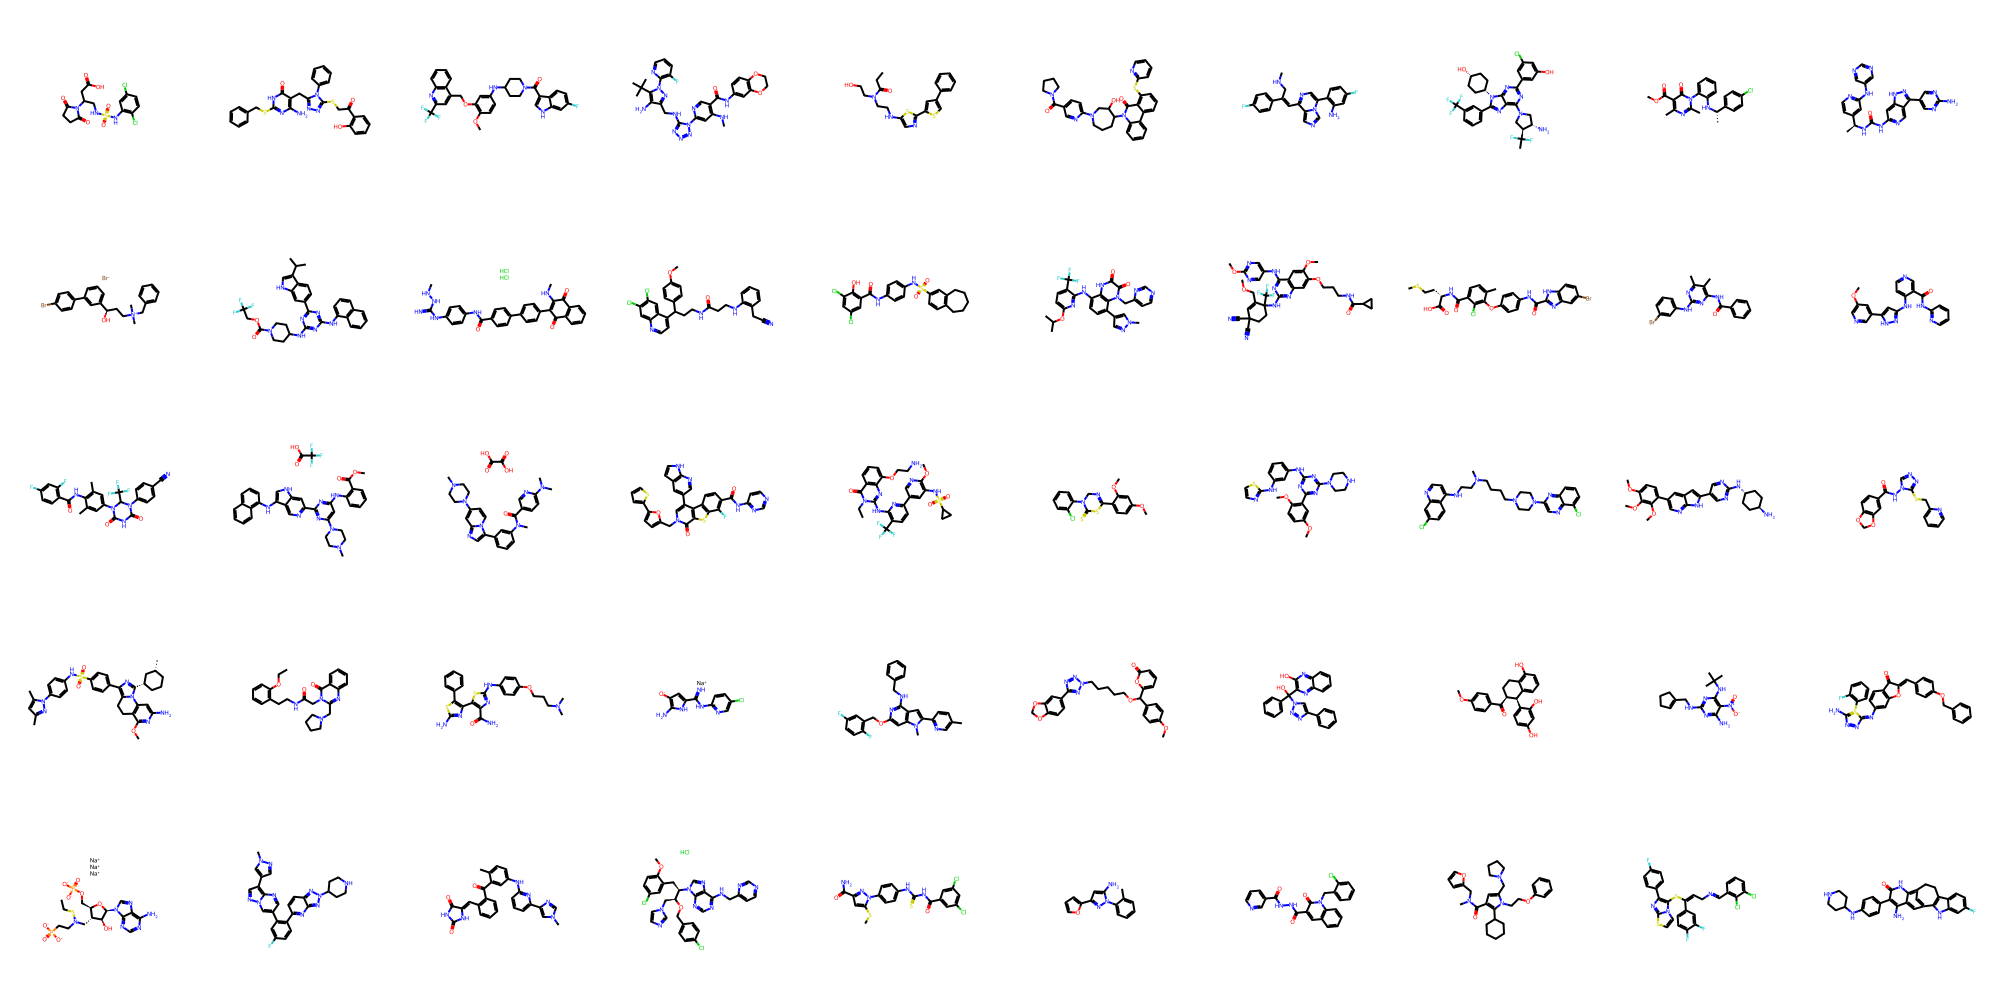

In [9]:
import deepsmiles
from rdkit import Chem
from rdkit.Chem import Draw
import torch

# Parameters
model_path = 'C:\\Users\\SchockWav3\\Desktop\\Masterarbeit\\modelle\\finetuned_model_without_transferlearning_2009.pth'
max_length = 100          # Maximum length of each generated DeepSMILES sequence
target_valid_smiles = 500 # Target number of valid SMILES strings
batch_size = 100           # Number of DeepSMILES sequences to generate at a time
output_file = "C:\\Users\\SchockWav3\\Desktop\\müll2.txt"  # Path for saving valid SMILES

# Set up device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def generate_and_get_smiles(model, max_length, model_path, target_valid_smiles, batch_size, output_file):
    """
    Generates DeepSMILES using a specified model and converts them to SMILES until a target number of valid SMILES is reached.
    Saves the valid generated SMILES to the specified output file.

    Args:
        model: The model to be used for generating DeepSMILES.
        max_length (int): The maximum length of each generated DeepSMILES sequence.
        model_path (str): The path to the model to be loaded.
        target_valid_smiles (int): The target number of valid SMILES strings.
        batch_size (int): The number of DeepSMILES sequences to generate at a time.
        output_file (str): The path to the file for saving valid SMILES strings.
    
    Returns:
        List[str]: A list of valid generated SMILES strings.
    """
    
    # Load the pretrained model and move it to the GPU
    model.load_pretrained_model(model_path)
    model.to(device)  # Move the model to the GPU
    
    # Initialize DeepSMILES converter
    converter = deepsmiles.Converter(rings=True, branches=True)
    
    valid_smiles = []
    total_invalid_smiles = 0
    total_generated = 0

    while len(valid_smiles) < target_valid_smiles:
        # Batch results
        batch_valid_smiles = 0
        batch_invalid_smiles = 0
        
        # Generate DeepSMILES in batches
        generated_deepsmiles = model.generate_deepsmiles(batch_size, max_length)
        
        # Convert DeepSMILES to SMILES and check validity
        for deep_smile in generated_deepsmiles:
            try:
                smile = converter.decode(deep_smile)
                mol = Chem.MolFromSmiles(smile)
                if mol and mol.GetNumAtoms() > 1:  # Check if valid and sufficiently complex
                    valid_smiles.append(smile)
                    batch_valid_smiles += 1
                    if len(valid_smiles) >= target_valid_smiles:
                        break
                else:
                    batch_invalid_smiles += 1
            except (deepsmiles.DecodeError, IndexError) as e:
                batch_invalid_smiles += 1
        
        # Update totals
        total_generated += len(generated_deepsmiles)
        total_invalid_smiles += batch_invalid_smiles
        
        # Print batch results
        print(f"Batch results: Valid SMILES: {batch_valid_smiles}, Invalid SMILES: {batch_invalid_smiles}")

    # Final output information
    print(f"\nFinal valid SMILES count: {len(valid_smiles)}")
    print(f"Total invalid SMILES: {total_invalid_smiles}")
    print(f"Total SMILES generated: {total_generated}")
    
    # Save valid SMILES to the specified output file
    save_smiles_to_file(valid_smiles, output_file)
    
    return valid_smiles, total_invalid_smiles


def save_smiles_to_file(smiles_list, file_name):
    """
    Saves a list of SMILES to a text file.

    Args:
        smiles_list (List[str]): A list of SMILES strings to save.
        file_name (str): The name of the output text file.
    """
    with open(file_name, 'w') as file:
        for smiles in smiles_list:
            file.write(smiles + '\n')
    print(f"Valid SMILES have been saved to {file_name}")


def validate_and_draw_smiles(smiles_list, images_per_row=10):
    """
    Validates and draws each SMILES in the provided list in a grid layout using Draw.MolsToGridImage.
    
    Args:
        smiles_list (List[str]): A list of SMILES strings to validate and draw.
        images_per_row (int): Number of images per row in the grid.
    """
    valid_mols = []
    for smiles in smiles_list:
        if smiles:  # Ensure the smile is not None
            mol = Chem.MolFromSmiles(smiles)
            if mol and mol.GetNumAtoms() > 1:  # Simple validity and complexity check
                valid_mols.append(mol)
    
    # Draw molecules in a grid and display as an image
    img = Draw.MolsToGridImage(valid_mols, molsPerRow=images_per_row, subImgSize=(200, 200))
    display(img)


# Generate and get valid SMILES
generated_smiles, invalid_smiles = generate_and_get_smiles(model, max_length, model_path, target_valid_smiles, batch_size, output_file)


# Validate and draw the generated valid SMILES in a grid (10 images per row)
validate_and_draw_smiles(generated_smiles, images_per_row=10)
